Calibrate the ITFR by fitting both galaxies in the Coma cluster and those used for 0-pt calibration simultaneously.

**Note**: This requires using a hacked version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

import os

import requests

import corner

import pickle

from help_functions import adjust_lightness

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
#sys.path.insert(1, '/Users/kellydouglass/Documents/Research/DESI/Targets/code/TF/')
from line_fits import param_invert, hyperfit_line_multi

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

# V0 is set to be the median value of all data used in the calibration

# Data

## fuji

In [3]:
# tfuji = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot.fits')
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
#tfuji = Table.read('/Users/kellydouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


## SGA

Read in our version of the SGA that includes distances from the Extragalactic Distance Database and Pantheon+SH0ES.  (This file was made with the `data_match.ipynb` notebook and the `data_match_PantheonSH0ES.ipynb` notebook.)

In [4]:
# SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
#SGA = Table.read('/Users/kellydouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')
SGA = Table.read('../SGA_distances.fits')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog,DM_PantheonSH0ES,e_DM_PantheonSH0ES,z_PantheonSH0ES,e_z_PantheonSH0ES,RA_PantheonSH0ES,DEC_PantheonSH0ES,CID_PantheonSH0ES
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes25,float64,float64,float64,float64,float64,float64,bytes15
5002480,SGA-2020 5002480,DR8-2837p402-5033,-1,283.619631436471,40.3162008554537,DEV,178.80934,0.54342,0.3166,-1.0,24.29036,16.9862,False,DR8,530781,DR8-2837p402-5033,1,True,283.619631436471,40.3162008554537,0.54342,2837p402,283.6196056669463,40.316337272867564,0.53864765,SB26,179.53694,0.3690244,283.6194583471782,40.31653379127378,11.641381,11.157478,8.614751,9.8993,1.6142721,3.685578,5.5844307,7.701021,9.878292,11.927793,13.400182,14.697571,16.15943,21.37251,20.373438,19.779512,19.920574,19.005274,18.41066,19.314016,18.435898,17.843414,18.922651,18.076838,17.494484,18.664383,17.833265,17.25879,18.496494,17.682926,17.106598,18.404135,17.605488,17.02742,18.332602,17.555883,16.971588,18.299273,17.52499,16.931496,0.04933311,0.065890566,0.09742977,0.10495926,0.1614855,0.27832195,0.15179653,0.13904023,0.20484819,0.041657884,0.06669066,0.06785251,0.038538612,0.049561314,0.05101378,0.03635901,0.041818976,0.042013034,0.03367074,0.03763669,0.03705858,0.03122176,0.03420294,0.0336

In [5]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## Separate the fuji data into center and off-center observations

In [6]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tfuji['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [7]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

### Clean the fuji center observations

Only keep those with
 * `DELTACHI2` > 25
 * `ZWARN` == 0

In [8]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [9]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

# Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [10]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [11]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]
mu_Coma = table3['DM'][Coma_row_t3][0]

Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

In [12]:
d_Coma = 10*10**(0.2*mu_Coma) # pc
V_Coma = 100*(d_Coma*1e-6) # km/s

V_Coma

7345.138681571143

## Calculate the projected distance between the Coma cluster and each SGA galaxy

In [13]:
# First, we need to convert R2t from Mpc to an angle, using the group's velocity
# Note that we are NOT assuming that the size of the cluster is a small angle!!
R2t_Coma_angle_1p5 = np.arctan(1.5*R2t_Coma/(d_Coma*1e-6))*u.radian
R2t_Coma_angle_3 = np.arctan(3*R2t_Coma/(d_Coma*1e-6))*u.radian

In [14]:
SGA_coords = SkyCoord(SGA['RA'], SGA['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [15]:
SGA_in_Coma1 = (sep < R2t_Coma_angle_1p5) & (SGA['Z_DESI']*c > V_Coma - 3*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= R2t_Coma_angle_1p5) & (sep < R2t_Coma_angle_3) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA['SGA_ID'][SGA_in_Coma]

centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
print('fuji off-center observations in Coma:', len(axis_inComa))

fuji galaxies in Coma with good center observations: 275
fuji off-center observations in Coma: 909


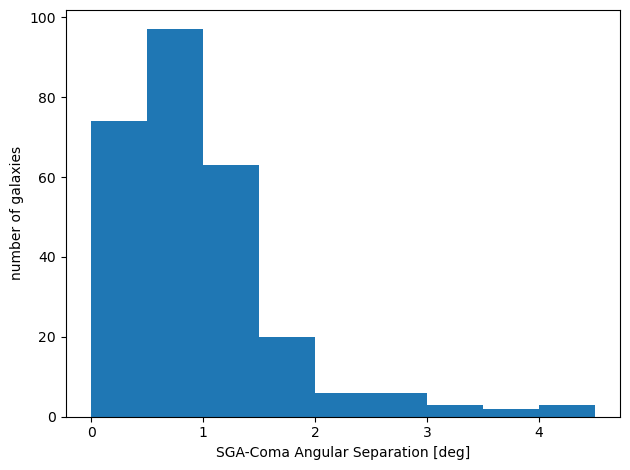

In [16]:
plt.figure(tight_layout=True)

plt.hist(sep[SGA_in_Coma].to_value('degree'), bins=np.arange(0, 5, 0.5))

plt.xlabel('SGA-Coma Angular Separation [deg]')
plt.ylabel('number of galaxies');

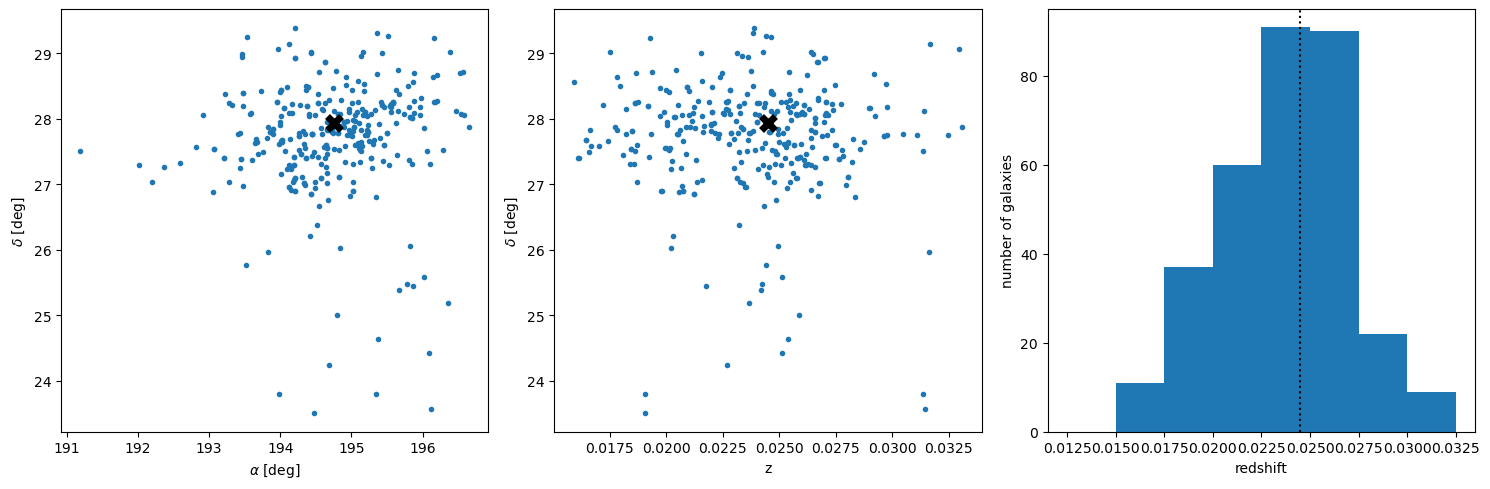

In [17]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_inComa['TARGET_RA'], centers_inComa['TARGET_DEC'], '.')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_inComa['Z'], centers_inComa['TARGET_DEC'], '.')
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_inComa['Z'], bins=np.arange(0.0125, 0.035, 0.0025))
plt.vlines(V_Coma/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=95);

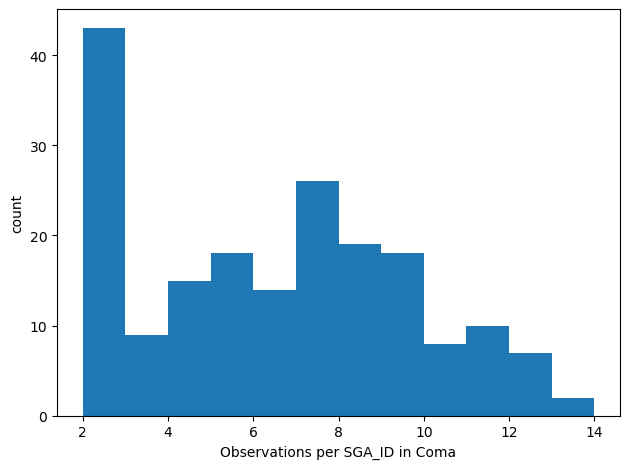

In [18]:
axis_SGAids, axis_counts = np.unique(axis_inComa['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_inComa['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Coma:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Coma')
plt.ylabel('count');

# 0-pt calibrators

Which objects with center observations also have independent distances?

In [19]:
distances = (SGA['DM_Stellar'] != -1) | (SGA['DM1_SN'] != -1) #| np.isfinite(SGA['DM_PantheonSH0ES'])
centers = np.isfinite(SGA['Z_DESI'])

################################################################################
# Keep all observations of each galaxy that have independent distances
#-------------------------------------------------------------------------------
SGA_ID_dist = SGA['SGA_ID'][distances & centers]

centers_dist = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_dist)]

axis_dist = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_dist)]
################################################################################

print('fuji galaxies with distances and good center observations:', len(np.unique(centers_dist['SGA_ID'])))
print('fuji off-center observations in galaxies with distances:', len(axis_dist))

fuji galaxies with distances and good center observations: 11
fuji off-center observations in galaxies with distances: 25


# Calculate the rotational velocity

## For Coma galaxies

In [20]:
axis_inComa['SKY_FIBER_DIST'] = 0.
axis_inComa['SKY_FIBER_DIST_R26'] = 0.
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_inComa['RA'][obs_idx], 
                             dec=axis_inComa['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_inComa['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_inComa['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

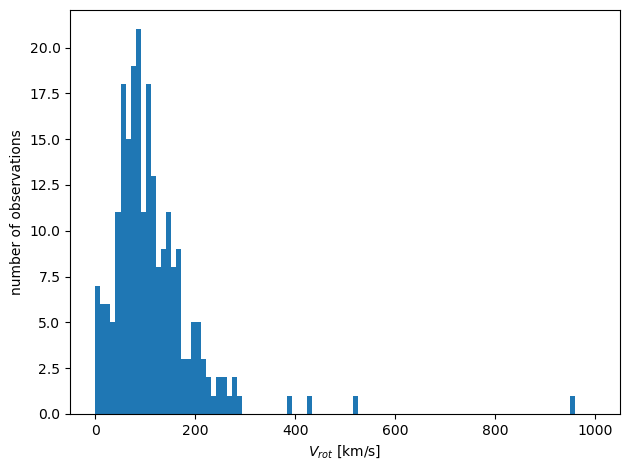

In [21]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_inComa['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

## For 0-pt calibrators

In [22]:
axis_dist['SKY_FIBER_DIST'] = 0.
axis_dist['SKY_FIBER_DIST_R26'] = 0.
axis_dist['V_ROT'] = np.nan
axis_dist['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_dist['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_dist['RA'][obs_idx], 
                             dec=axis_dist['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_dist['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_dist['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_dist['V_ROT'][obs_idx] = c*(axis_dist['Z'][obs_idx] - z_center)
    axis_dist['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_dist['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_dist['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

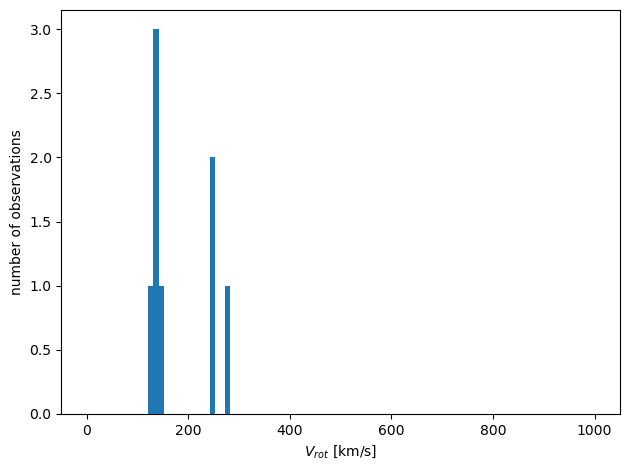

In [23]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_dist['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for galaxies suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [24]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(axis_inComa['V_ROT']) < 1000) & (np.abs(axis_inComa['V_ROT']) > 10)

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

193 113


In [25]:
r0p3_0pt = (axis_dist['SKY_FIBER_DIST_R26'] > 0.3) & (axis_dist['SKY_FIBER_DIST_R26'] < 0.4)

Vgood_0pt = (np.abs(axis_dist['V_ROT']) < 1000) & (np.abs(axis_dist['V_ROT']) > 10)

good_axis_dist = axis_dist[r0p3_0pt & Vgood_0pt]

print(len(good_axis_dist), len(np.unique(good_axis_dist['SGA_ID'])))

7 3


## Relative velocity cut

In [26]:
good_deltaV = np.ones(len(good_axis_inComa), dtype=bool)

for sga_id in np.unique(good_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_inComa['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_inComa['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

In [27]:
good_deltaV_axis_inComa = good_axis_inComa[good_deltaV]

print(len(good_deltaV_axis_inComa), len(np.unique(good_deltaV_axis_inComa['SGA_ID'])))

185 110


In [28]:
good_deltaV_0pt = np.ones(len(good_axis_dist), dtype=bool)

for sga_id in np.unique(good_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_dist['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_dist['DELTACHI2'] >= 25
            
            good_deltaV_0pt[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_dist['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV_0pt[good_obs_idx] = False

In [29]:
good_deltaV_axis_dist = good_axis_dist[good_deltaV_0pt]

print(len(good_deltaV_axis_dist), len(np.unique(good_deltaV_axis_dist['SGA_ID'])))

7 3


## Inclination angle cut

In [30]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

i_min = 45. # degrees
cosi2_max = np.cos(i_min*np.pi/180.)**2

In [31]:
good_deltaV_axis_inComa['iSGA'] = -1

for i in range(len(good_deltaV_axis_inComa)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_inComa['SGA_ID'][i]]
    
    good_deltaV_axis_inComa['iSGA'][i] = sga_idx
    
good_deltaV_axis_inComa['cosi2'] = SGA['cosi2'][good_deltaV_axis_inComa['iSGA']]

In [32]:
edge = good_deltaV_axis_inComa['cosi2'] <= cosi2_max

good_edge_axis_inComa = good_deltaV_axis_inComa[edge]

print(len(good_edge_axis_inComa), len(np.unique(good_edge_axis_inComa['SGA_ID'])))

150 91


In [33]:
good_deltaV_axis_dist['iSGA'] = -1

for i in range(len(good_deltaV_axis_dist)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_dist['SGA_ID'][i]]
    
    good_deltaV_axis_dist['iSGA'][i] = sga_idx
    
good_deltaV_axis_dist['cosi2'] = SGA['cosi2'][good_deltaV_axis_dist['iSGA']]

In [34]:
edge_0pt = good_deltaV_axis_dist['cosi2'] <= cosi2_max

good_edge_axis_dist = good_deltaV_axis_dist[edge_0pt]

print(len(good_edge_axis_dist), len(np.unique(good_edge_axis_dist['SGA_ID'])))

6 2


## Morphology cut

In [35]:
good_edge_axis_inComa['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_inComa['iSGA']]

In [36]:
spirals = np.zeros(len(good_edge_axis_inComa), dtype=bool)

for i in range(len(good_edge_axis_inComa)):
    
    try:    
        if (good_edge_axis_inComa['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_inComa['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_inComa['MORPHTYPE'][i])

good_edge_spirals_axis_inComa = good_edge_axis_inComa[spirals]

print(len(good_edge_spirals_axis_inComa), len(np.unique(good_edge_spirals_axis_inComa['SGA_ID'])))

80 45


In [37]:
good_edge_axis_dist['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_dist['iSGA']]

In [38]:
spirals_0pt = np.zeros(len(good_edge_axis_dist), dtype=bool)

for i in range(len(good_edge_axis_dist)):
    
    try:    
        if (good_edge_axis_dist['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_dist['MORPHTYPE'][i][:2] != 'S0'):
            spirals_0pt[i] = True
        elif good_edge_axis_dist['MORPHTYPE'][i] == 'N/A':
            spirals_0pt[i] = True
    except IndexError:
        print(good_edge_axis_dist['MORPHTYPE'][i])

good_edge_spirals_axis_dist = good_edge_axis_dist[spirals_0pt]

print(len(good_edge_spirals_axis_dist), len(np.unique(good_edge_spirals_axis_dist['SGA_ID'])))

6 2


## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [36]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [37]:
for sga_id in np.unique(good_edge_spirals_axis_inComa['SGA_ID']):
    
    tf_list = good_edge_spirals_axis_inComa[good_edge_spirals_axis_inComa['SGA_ID'] == sga_id]
    center_list = centers_inComa[centers_inComa['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    '''
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    
    break
    ''';

Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.97667146704435&dec=28.31062379047577&zoom=14&layer=ls-dr9&size=185&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.04313321875534&dec=27.959071290945204&zoom=14&layer=ls-dr9&size=110&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=194.20691376173056&dec=27.093895925073287&zoom=14&layer=ls-dr9&size=328&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.84774376778842&dec=27.30687826270548&zoom=14&layer=ls-dr9&size=104&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=194.57594096774397&dec=27.848482700176607&zoom=14&layer=ls-dr9&size=159&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=193.63830652599466&dec=27.63275185427826&zoom=14&layer=ls-dr9&size=348&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.21296726515683&dec=27.742983900813208&zoom=14&layer=ls-dr9&size=177&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=193.06742023100352&dec=27.5331587436960

In [39]:
VI_remove = Table.read('fuji_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_inComa), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_inComa['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_inComa = good_edge_spirals_axis_inComa[~remove_targets]

print(len(VI_good_edge_spirals_axis_inComa), len(np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID'])))

80 45


Both of the 0-pt calibrators pass VI.

# Coma TFR

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [40]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_inComa['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_inComa['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [41]:
# Make a catalog of just Coma galaxies with velocities
SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

In [42]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

good_edge_spirals_axis_dist['R_MAG_SB26'] = np.nan
good_edge_spirals_axis_dist['R_MAG_SB26_ERR'] = np.nan

weights = 1./(good_edge_spirals_axis_dist['V_ROT_ERR']**2)

for sga_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_edge_spirals_axis_dist['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(good_edge_spirals_axis_dist['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [43]:
# Make a catalog of just 0-pt galaxies with velocities
SGA_0pt = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

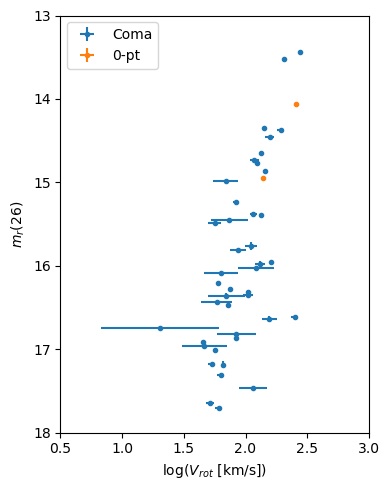

In [44]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.', 
             label='Coma')

plt.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_MAG_SB26'], 
             xerr=0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_MAG_SB26_ERR'], 
             fmt='.', 
             label='0-pt')

plt.xlim([0.5, 3])
plt.ylim([18, 13])

plt.legend()

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

# Compute the absolute magnitudes for the 0-pt calibrators based on the distance measurements

\begin{equation}
  M_r - 5\log h = m_r - \mu - 5\log h
\end{equation}
where $h$ is the reduced Hubble constant used to calibrate the distance modulus, $\mu$.

Both of our galaxies have distance moduli from Stahl et al. (2021), which *appears* to use $h = 1$.  Therefore, the distance moduli we have to use are $\mu_h = \mu - 5\log h$.

The third galaxy has a distance moduli from Pantheon+SH0ES, whose distances are based on distance ladder calibrations, so there is no assumption of $h$.

In [45]:
SGA_0pt['R_ABSMAG_SB26'] = SGA_0pt['R_MAG_SB26'] - SGA_0pt['DM1_SN'] #+ 5*np.log10(0.7)
SGA_0pt['R_ABSMAG_SB26_err'] = np.sqrt(SGA_0pt['R_MAG_SB26_ERR']**2 + SGA_0pt['e_DM1_SN']**2)

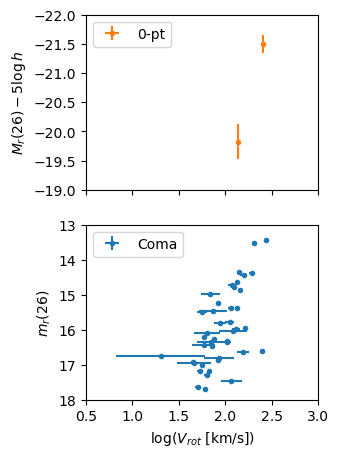

In [46]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(3,5))

ax2.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.', 
             label='Coma')

ax1.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_ABSMAG_SB26_err'], 
             fmt='.', 
             c='tab:orange',
             label='0-pt')

plt.xlim([0.5, 3])
ax1.set_ylim([-19, -22])
ax2.set_ylim([18, 13])

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.xlabel('log($V_{rot}$ [km/s])')
ax1.set_ylabel('$M_r (26) - 5\log h$')
ax2.set_ylabel('$m_r (26)$');

# Fit the TFR using the hacked version of `hyperfit`

In [47]:
V0 = np.median(np.concatenate([np.log10(SGA_TF['V_0p33R26']), np.log10(SGA_0pt['V_0p33R26'])]))
print(V0)

1.9789831722918412


In [48]:
# bounds_tfr = ((-20.0, 0.0), (0.0, 20.0), (-30.0, 0.0), (1.0e-5, 5.0))
bounds_itfr = ((-20.0, 20.0), (0.0, 20.0), (-20.0, 0.0), (1.0e-5, 5.0))

w0, w1, sig_w, cov_w, itfr_mcmc_samples, hf_itfr = hyperfit_line_multi([SGA_TF['R_MAG_SB26'], SGA_0pt['R_ABSMAG_SB26']],
                                                                       [np.log10(SGA_TF['V_0p33R26']) - V0, np.log10(SGA_0pt['V_0p33R26']) - V0], 
                                                                       [SGA_TF['R_MAG_SB26_ERR'], SGA_0pt['R_ABSMAG_SB26_err']], 
                                                                       [0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'], 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']], 
                                                                       bounds_itfr)

     fun: -2394.1313499219077
     jac: array([-0.00891305, -0.45547495, -0.44801709,  0.22619133])
 message: 'Optimization terminated successfully.'
    nfev: 6225
     nit: 102
 success: True
       x: array([-0.12819436,  2.04898477, -2.34096255,  0.14053012])


100%|██████████| 1000/1000 [00:01<00:00, 574.73it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.23793942 38.08737095 36.17354351 30.74289733] / 1911.8969707504782


100%|██████████| 1000/1000 [00:01<00:00, 570.39it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.848063   36.47699042 38.18632411 45.17530708] / 2258.765353860679


100%|██████████| 1000/1000 [00:01<00:00, 578.94it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.45772287 37.87667455 38.70692907 39.33319982] / 1966.6599911238177


100%|██████████| 1000/1000 [00:01<00:00, 559.15it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.09962763 37.38784438 37.46876687 48.23624455] / 2411.8122273199942


100%|██████████| 1000/1000 [00:01<00:00, 558.16it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.64937318 40.16080476 40.10808534 45.95142904] / 2297.571451917751


100%|██████████| 1000/1000 [00:01<00:00, 597.30it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.59026159 42.39342341 42.39524518 49.50193138] / 2475.0965689122295


100%|██████████| 1000/1000 [00:01<00:00, 590.12it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.87729437 49.25820893 51.39048504 46.69790408] / 2569.5242521180626


100%|██████████| 1000/1000 [00:01<00:00, 583.68it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [52.38460034 51.89950797 53.54095034 50.22610651] / 2677.0475169387264


100%|██████████| 1000/1000 [00:01<00:00, 587.90it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [59.1834833  59.28487256 60.59067425 48.35188868] / 3029.5337123907366


100%|██████████| 1000/1000 [00:01<00:00, 588.35it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [55.90948578 56.50639402 57.37917421 46.39438077] / 2868.95871064455


100%|██████████| 1000/1000 [00:01<00:00, 559.59it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [54.11335326 53.87248008 54.95155931 45.96175505] / 2747.577965637911


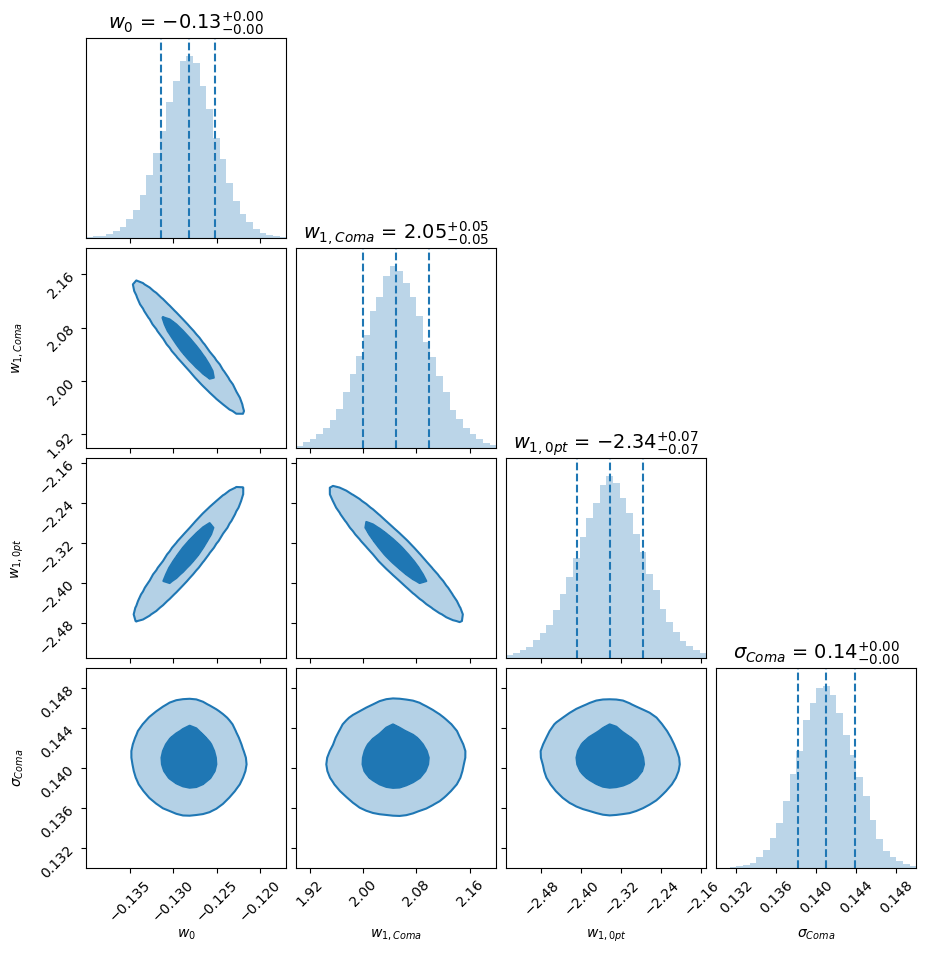

In [49]:
fig = corner.corner(itfr_mcmc_samples.T, bins=30, smooth=1,
                    range=[[-0.14, -0.117], [1.9, 2.2], [-2.55, -2.15], [0.13, 0.15]],   # Range for w0, w1, sigma. Adjust as needed.
                    # range=[[-8.4, -7.2], [15.85, 16.1], [-18.6, -17.8], [1, 1.2]], # Range for a, b, sigma.  Adjust as needed.
                    labels=['$w_0$', '$w_{1, Coma}$', '$w_{1, 0 pt}$', r'$\sigma_{Coma}$'],
                    # labels=['$a$', '$b_{Coma}$', '$b_{0 pt}$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14});

In [50]:
a_itfr, b_itfr, cov_itfr = param_invert(w0, w1, cov_w[:3,:3])

print(f'              w0: {w0:.3f} +/- {np.sqrt(cov_w[0,0]):.3f}')
print(f'         w1 Coma: {w1[0]:.2f}  +/- {np.sqrt(cov_w[1,1]):.2f}')
print(f'          w1 0pt: {w1[1]:.2f}  +/- {np.sqrt(cov_w[2,2]):.2f}')
print(f'           slope: {a_itfr:.2f}  +/- {np.sqrt(cov_itfr[0,0]):.2f}')
print(f'y-intercept Coma: {b_itfr[0]:.2f}  +/- {np.sqrt(cov_itfr[1,1]):.2f}')
print(f' y-intercept 0pt: {b_itfr[1]:.2f}  +/- {np.sqrt(cov_itfr[2,2]):.2f}')

              w0: -0.128 +/- 0.003
         w1 Coma: 2.05  +/- 0.05
          w1 0pt: -2.34  +/- 0.07
           slope: -7.80  +/- 0.20
y-intercept Coma: 15.98  +/- 0.03
 y-intercept 0pt: -18.27  +/- 0.13


### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [55]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples = np.zeros(itfr_mcmc_samples.shape)

tfr_mcmc_samples[0] = 1./itfr_mcmc_samples[0]
tfr_mcmc_samples[1] = -itfr_mcmc_samples[1]/itfr_mcmc_samples[0]
tfr_mcmc_samples[2] = -itfr_mcmc_samples[2]/itfr_mcmc_samples[0]
tfr_mcmc_samples[3] = itfr_mcmc_samples[3]

In [56]:
# temp_outfile = open('mcmc_fuji_Coma_ITFR_KAD-V0_' + str(V0) + '.pickle', 'wb')
# pickle.dump((cov_w, cov_itfr, itfr_mcmc_samples, tfr_mcmc_samples), temp_outfile)
# temp_outfile.close()

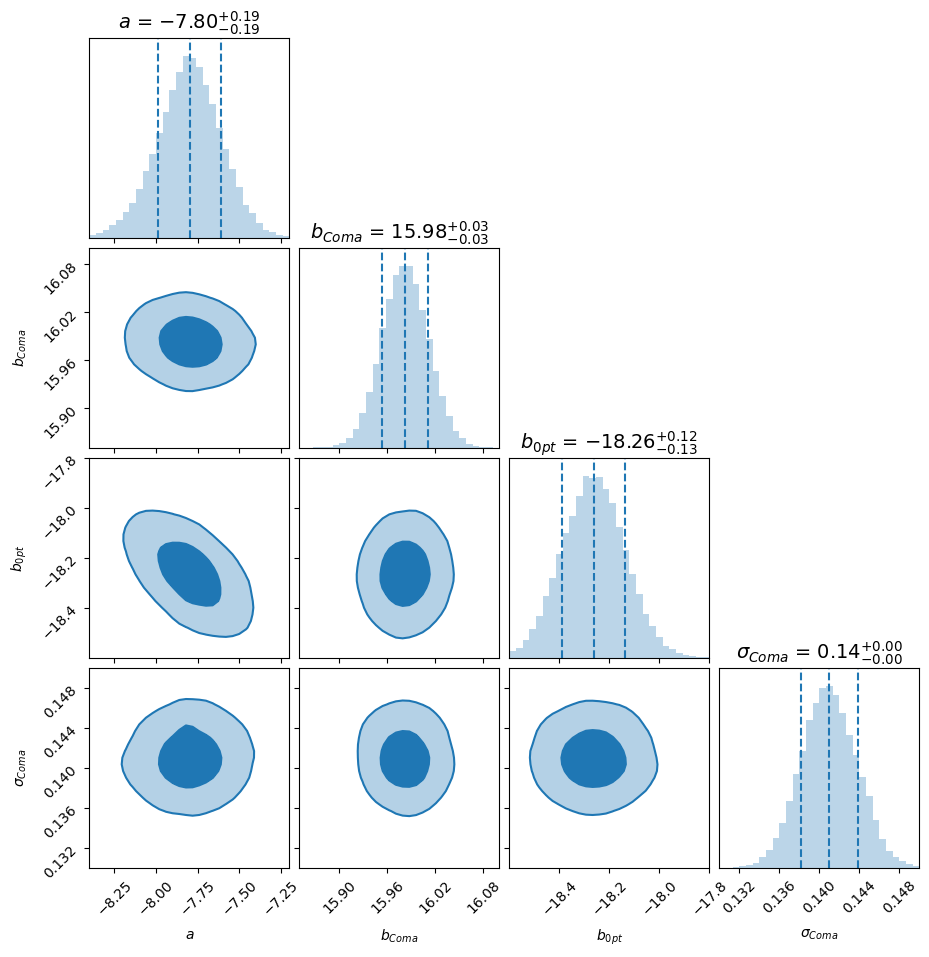

In [57]:
fig = corner.corner(tfr_mcmc_samples.T, bins=30, smooth=1,
                    # range=[[-12, -4], [10, 13.5], [0.05, 0.25]],   # Range for a, b, sigma. Adjust as needed.
                    # range=[[-12, -4], [15, 17], [0.05, 0.25]], # V0 = 2.0
                    # range=[[-12, -4], [12, 15], [0.05, 0.25]], # V0 = 2.25
                    # range=[[-12, -4], [17, 19], [0.05, 0.25]], # V0 = 1.75
                    range=[[-8.4, -7.2], [15.85, 16.1], [-18.6, -17.8], [0.13, 0.15]],
                    labels=['$a$', '$b_{Coma}$', '$b_{0pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14})

# fig.savefig('../../Figures/SV/fuji_Coma_corner_20240130.png', dpi=150)

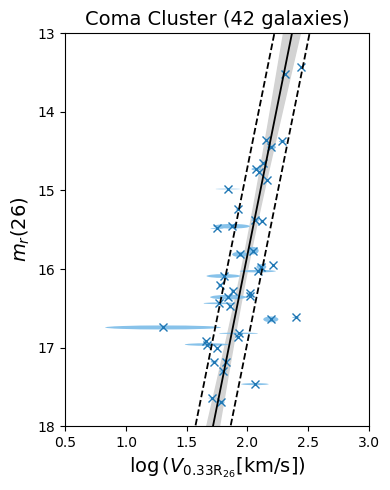

In [61]:
sigmas = hf_itfr.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = a_itfr * (xvals - V0) + b_itfr

################################################################################
# Get the MCMC 1-sigma quantiles to plot with the fit.
#-------------------------------------------------------------------------------
y_chain1 = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[1]
y_chain1_quantiles = np.quantile(y_chain1, [0.1587, 0.8414], axis=1)

y_chain2 = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[2]
y_chain2_quantiles = np.quantile(y_chain2, [0.1587, 0.8414], axis=1)
################################################################################


################################################################################
# Pack info into data
#-------------------------------------------------------------------------------
data1 = [np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26']]
x1_err = 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26']
y1_err = SGA_TF['R_MAG_SB26_ERR']
corr1_xy = np.zeros_like(x1_err)

data2 = [np.log10(SGA_0pt['V_0p33R26']), SGA_0pt['R_ABSMAG_SB26']]
x2_err = 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']
y2_err = SGA_0pt['R_ABSMAG_SB26_err']
corr2_xy = np.zeros_like(x2_err)
################################################################################


################################################################################
# Generate ellipses
#-------------------------------------------------------------------------------
ells1 = [
    Ellipse(
        xy=[data1[0][i], data1[1][i]],
        width=2*y1_err[i],
        height=2*x1_err[i],
        angle=np.rad2deg(np.arccos(corr1_xy[i])),
    )
    for i in range(len(data1[0]))
]

ells2 = [
    Ellipse(
        xy=[data2[0][i], data2[1][i]],
        width=2*y2_err[i],
        height=2*x2_err[i],
        angle=np.rad2deg(np.arccos(corr2_xy[i])),
    )
    for i in range(len(data2[0]))
]
################################################################################


################################################################################
# Make the plot
#-------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, figsize=(3,5), tight_layout=True, sharex=True)

ax2.fill_between(xvals, 
                 y_chain1_quantiles[0], 
                 y_chain1_quantiles[1], 
                 color="lightgray")

for i, e in enumerate(ells2):
    ax2.add_artist(e)
    #e.set_edgecolor('None')
    e.set_facecolor(adjust_lightness('tab:blue', amount=1.75))
    
ax2.plot(data2[0], data2[1], 'x')

ax2.plot(xvals, yvals[1], c="k", marker="None", ls="-", lw=1.3)
ax2.plot(xvals - hf_itfr.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)
ax2.plot(xvals + hf_itfr.vert_scat, yvals, c="k", marker="None", ls="--", lw=1.3)

ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$m_r(26)$", fontsize=14)

ax.set_title("Coma Cluster ({} galaxies)".format(len(SGA_TF)), fontsize = 14)

ax.set_xlim(0.5, 3)
ax.set_ylim(18, 13);
################################################################################

# plt.savefig('../../Figures/SV/fuji_Coma_TFR_20240130.png', dpi=150)

In [58]:
hf_itfr.get_sigmas()

AttributeError: 'MultiLinFit' object has no attribute 'get_sigmas'